# Lecture 10 – Data 100, Fall 2024

Data 100, Fall 2024

[Acknowledgments Page](https://ds100.org/fa24/acks/)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Correlation

Recreate the 4 correlation plots in slides. (This wouldn't normally be in the notebook, but it might be of interest to you.)

Note: We use `np.corrcoef` to compute the correlation coefficient $r$, though we could also compute it manually.

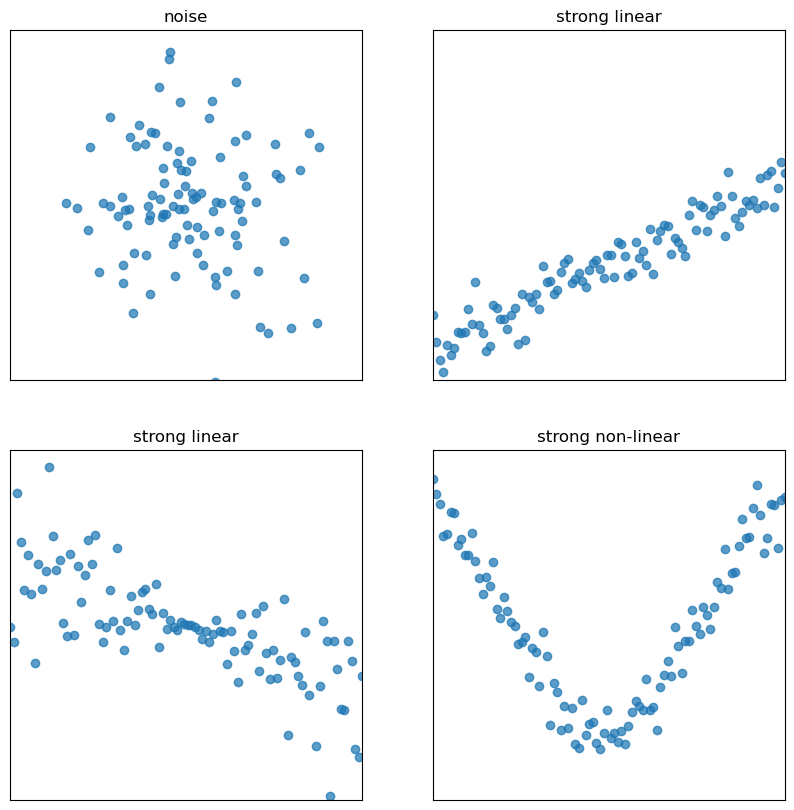

[-0.12066459676011669, 0.9508258477335819, -0.7230212909978788, 0.05635571445630123]


In [2]:
# Set random seed recreate same random points as slides
np.random.seed(43)
plt.style.use('default') # Revert style to default mpl

def plot_and_get_corr(ax, x, y, title):
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.scatter(x, y, alpha = 0.73)
    ax.set_title(title)
    return np.corrcoef(x, y)[0, 1]

fig, axs = plt.subplots(2, 2, figsize = (10, 10))

# Just noise
x1, y1 = np.random.randn(2, 100)
corr1 = plot_and_get_corr(axs[0, 0], x1, y1, title = "noise")

# Strong linear
x2 = np.linspace(-3, 3, 100)
y2 = x2 * 0.5 - 1 + np.random.randn(100) * 0.3
corr2 = plot_and_get_corr(axs[0, 1], x2, y2, title = "strong linear")

# Unequal spread
x3 = np.linspace(-3, 3, 100)
y3 = - x3/3 + np.random.randn(100)*(x3)/2.5
corr3 = plot_and_get_corr(axs[1, 0], x3, y3, title = "strong linear")
extent = axs[1, 0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())

# Strong non-linear
x4 = np.linspace(-3, 3, 100)
y4 = 2*np.sin(x3 - 1.5) + np.random.randn(100) * 0.3
corr4 = plot_and_get_corr(axs[1, 1], x4, y4, title = "strong non-linear")

plt.show()
print([corr1, corr2, corr3, corr4])

## Which $\theta$ is best?


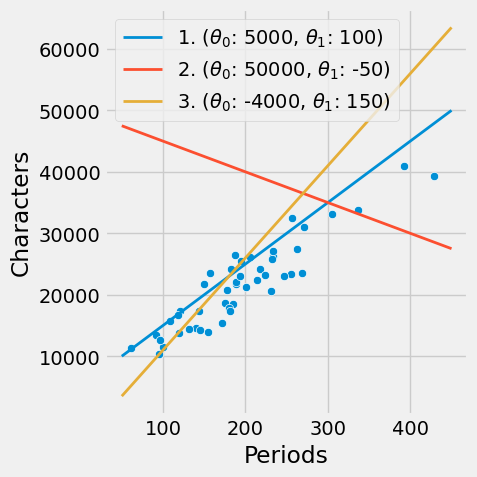

In [3]:
plt.style.use('fivethirtyeight')
lw = pd.read_csv("data/little_women.csv")
fig = plt.figure(figsize = (5, 5))
ax = plt.gca()
sns.scatterplot(data=lw, x="Periods", y="Characters", ax=ax)

xlims = np.array([50, 450])
params = [[5000, 100], [50000, -50], [-4000, 150]]
for i, (theta_0, theta_1) in enumerate(params):
    ax.plot(xlims, theta_0 + theta_1 * xlims, lw=2, label=f"{i+1}. ($\\theta_0$: {theta_0}, $\\theta_1$: {theta_1})")
ax.legend()

# The best parameters weren't one of the choices
ahat_true, bhat_true = 4745, 87
fig.tight_layout()
# plt.savefig('lw_params.png')

## Simple Linear Regression

First, let's implement the tools we'll need for regression.

In [4]:
def standard_units(x):
    return (x - np.mean(x)) / np.std(x)

def correlation(x, y):
    return np.mean(standard_units(x) * standard_units(y))

In [5]:
def slope(x, y):
    return correlation(x, y) * np.std(y) / np.std(x)

def intercept(x, y):
    return np.mean(y) - slope(x, y) * np.mean(x)

# Evaluating the Model

In [6]:
# Helper functions
def fit_least_squares(x, y):
    theta_0 = intercept(x, y)
    theta_1 = slope(x, y)
    return theta_0, theta_1

def predict(x, theta_0, theta_1):
    return theta_0 + theta_1 * x

def compute_mse(y, yhat):
    return np.mean((y - yhat) ** 2)

Below, we define `least_squares_evaluation`, which:
* Computes general data statistics like mean, standard deviation, and linear correlation $r$
* Fits least squares to data of the form $(x, y)$
* Computes performance metrics like RMSE
* Plots two visualizations:
    * Original scatter plot with a fitted line
    * Residual plot

In [7]:
plt.style.use('default') # Revert style to default mpl
NO_VIZ, RESID, RESID_SCATTER = range(3)
def least_squares_evaluation(x, y, visualize = NO_VIZ):
    theta_0, theta_1 = fit_least_squares(x, y)
    yhat = predict(x, theta_0, theta_1)
    
    # Statistics Performance metrics
    if visualize == NO_VIZ:
        print(f"x_mean : {np.mean(x):.2f}, y_mean : {np.mean(y):.2f}")
        print(f"x_stdev: {np.std(x):.2f}, y_stdev: {np.std(y):.2f}")
        print(f"r = Correlation(x, y): {correlation(x, y):.3f}")
        print(f"theta_0: {theta_0:.2f}, theta_1: {theta_1:.2f}")
        print(f"RMSE: {np.sqrt(compute_mse(y, yhat)):.3f}")
    
    # Visualization
    fig, axs = None, None
    if visualize == RESID:
        fig = plt.figure(figsize = (4, 3))
        plt.scatter(x, y - yhat, color = 'red')
        plt.axhline(y = 0, xmin = 0, xmax = 500)
        fig.axes[0].set_title("Residuals")
        
        
    if visualize == RESID_SCATTER:
        fig, axs = plt.subplots(1, 2, figsize = (8, 3))
        axs[0].scatter(x, y)
        axs[0].plot(x, yhat)
        axs[0].set_title("LS fit")
        axs[1].scatter(x, y - yhat, color = 'red')
        axs[1].axhline(y = 0, xmin = 0, xmax = 500)

Let's first try just doing linear fit *without* visualizing data.

**Note**: Computation without visualization is NOT a good practice! We are doing the three evaluation steps **out of order** to highlight the importance of visualization.

Here are the evaluation steps **in order**:
1. Visualize original data and compute statistics.
2. If it seems reasonable, fit the linear model.
3. Finally, compute performance metrics of linear model and plot residuals and other visualizations.

### Compute statistics and performance metrics only (Anscombe's Quartet)

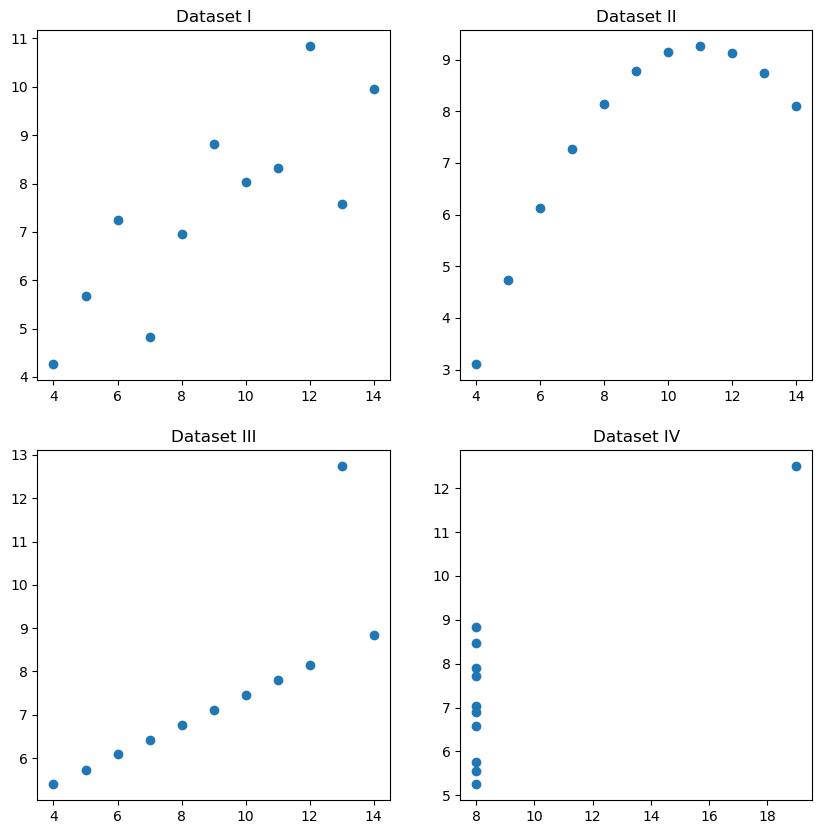

In [8]:
x = [10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5]
y1 = [8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68]
y2 = [9.14, 8.14, 8.74, 8.77, 9.26, 8.10, 6.13, 3.10, 9.13, 7.26, 4.74]
y3 = [7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73]
x4 = [8, 8, 8, 8, 8, 8, 8, 19, 8, 8, 8]
y4 = [6.58, 5.76, 7.71, 8.84, 8.47, 7.04, 5.25, 12.50, 5.56, 7.91, 6.89]

anscombe = {
    'I': pd.DataFrame(list(zip(x, y1)), columns =['x', 'y']),
    'II': pd.DataFrame(list(zip(x, y2)), columns =['x', 'y']),
    'III': pd.DataFrame(list(zip(x, y3)), columns =['x', 'y']),
    'IV': pd.DataFrame(list(zip(x4, y4)), columns =['x', 'y'])
}

fig, axs = plt.subplots(2, 2, figsize = (10, 10))

for i, dataset in enumerate(['I', 'II', 'III', 'IV']):
    ans = anscombe[dataset]
    axs[i//2, i%2].scatter(ans['x'], ans['y'])
    axs[i//2, i%2].set_title(f"Dataset {dataset}")

plt.show()
    

In [9]:
for dataset in ['I', 'II', 'III', 'IV']:
    print(f">>> Dataset {dataset}:")
    ans = anscombe[dataset]
    least_squares_evaluation(ans['x'], ans['y'], visualize = NO_VIZ)
    print()
    print()

>>> Dataset I:
x_mean : 9.00, y_mean : 7.50
x_stdev: 3.16, y_stdev: 1.94
r = Correlation(x, y): 0.816
theta_0: 3.00, theta_1: 0.50
RMSE: 1.119


>>> Dataset II:
x_mean : 9.00, y_mean : 7.50
x_stdev: 3.16, y_stdev: 1.94
r = Correlation(x, y): 0.816
theta_0: 3.00, theta_1: 0.50
RMSE: 1.119


>>> Dataset III:
x_mean : 9.00, y_mean : 7.50
x_stdev: 3.16, y_stdev: 1.94
r = Correlation(x, y): 0.816
theta_0: 3.00, theta_1: 0.50
RMSE: 1.118


>>> Dataset IV:
x_mean : 9.00, y_mean : 7.50
x_stdev: 3.16, y_stdev: 1.94
r = Correlation(x, y): 0.817
theta_0: 3.00, theta_1: 0.50
RMSE: 1.118




Wow, looks like all four datasets have the same:
* Statistics of $x$ and $y$
* Correlation $r$
* Regression line parameters $\hat{a}, \hat{b}$
* RMSE (average squared loss)

### Plot Residuals

>>> Dataset I:


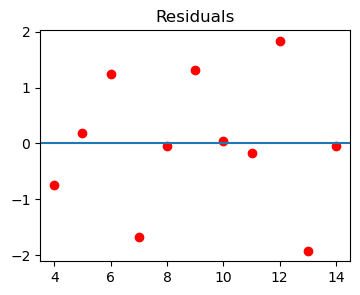



>>> Dataset II:


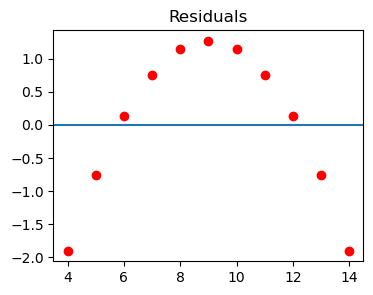



>>> Dataset III:


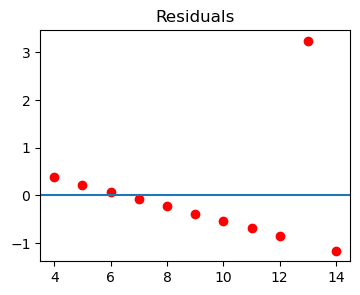



>>> Dataset IV:


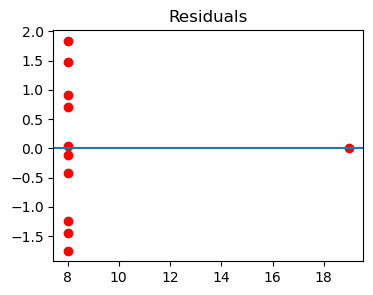

In [10]:
for dataset in ['I', 'II', 'III', 'IV']:
    print(f">>> Dataset {dataset}:")
    ans = anscombe[dataset]
    fig = least_squares_evaluation(ans['x'], ans['y'], visualize = RESID)
    plt.show(fig)
    print()
    print()

### Visualize the original data (what we should have done at the beginning)

>>> Dataset I:


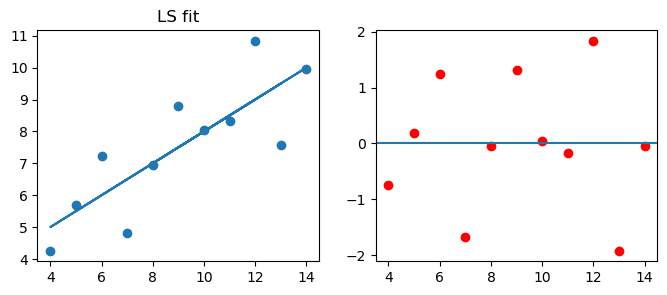



>>> Dataset II:


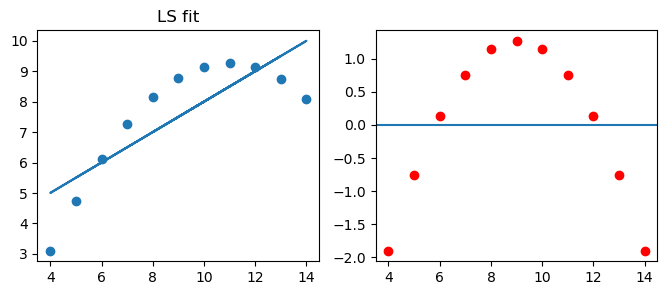



>>> Dataset III:


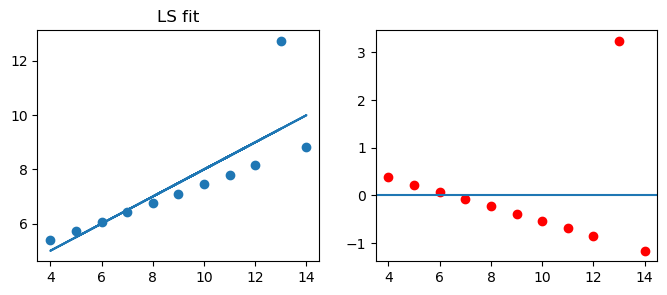



>>> Dataset IV:


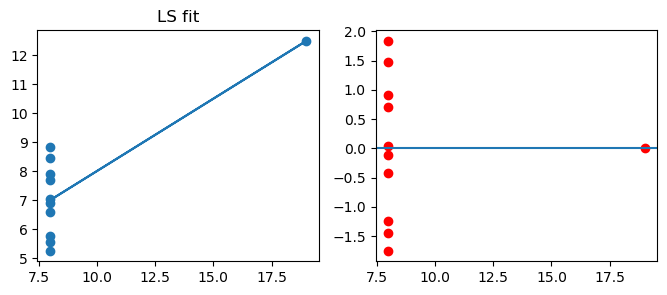

In [11]:
for dataset in ['I', 'II', 'III', 'IV']:
    print(f">>> Dataset {dataset}:")
    ans = anscombe[dataset]
    fig = least_squares_evaluation(ans['x'], ans['y'], visualize = RESID_SCATTER)
    plt.show(fig)
    print()
    print()